<a href="https://colab.research.google.com/github/Ayikanying-ux/multi_class_classification_on_stack_overflow_questions/blob/main/multi_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
import collections
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

!pip install tensorflow_text
import tensorflow_datasets as tfds
import tensorflow_text as tf_text


## Download dataset.
Here we will be using the dataset from tensorflow to predict the correct label os each question posted on stack overflow

In [2]:
url="https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
dataset = tf.keras.utils.get_file("stack_overflow_16k_v1", url,
                                 untar=True, cache_dir="stack_overflow",
                                 cache_subdir=""
                                 )
dataset_dir = pathlib.Path(dataset).parent

6053168/6053168 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
list(dataset_dir.iterdir())

[PosixPath('/tmp/.keras/train'),
 PosixPath('/tmp/.keras/stack_overflow_16k_v1.tar.gz'),
 PosixPath('/tmp/.keras/test'),
 PosixPath('/tmp/.keras/README.md')]

As we can see after downloading the datset we have a test directory for testing and train directory for training the model.

Lest take a look at the train folder to see how the data is organised.

In [4]:
train_dir = dataset_dir / 'train'
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/csharp'),
 PosixPath('/tmp/.keras/train/python'),
 PosixPath('/tmp/.keras/train/java'),
 PosixPath('/tmp/.keras/train/javascript')]

We can see that we have 4 folders which represents the class label and they contain the questions which we need to trian.

Let's take a look at on of the questions.

In [5]:
sample_file = train_dir / 'python/1755.txt'
with open(sample_file) as f:
  print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



## Load the dataset
Next is to load the dataset and prepare it for training in a format suitable for training

In [6]:
batch_size=32
seed=42
train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


Let's take a look at some of the texts and their labels

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label: ", label_batch.numpy()[i])

Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default con

In [8]:
for i, label in enumerate(train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


Let's now create the validation and test set using the remaining dataset

In [9]:
train_val = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [10]:
test_dir = dataset_dir/'test'

test_ds = utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


## Configure the dataset for performance

In [11]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
train_val = train_val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Let's create a TextVectorization layer to standardize, vectorize and tokenize our data

In [12]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary'
)

In [13]:
sequence_length=250

int_vectorize_layer=layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=sequence_length
)

In [14]:
train_text = train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [15]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Review", first_question)
print("Label", first_label)

Review tf.Tensor(b'"blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    public

'binary' vectorize_layer question: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

(0.0, 1000.0)

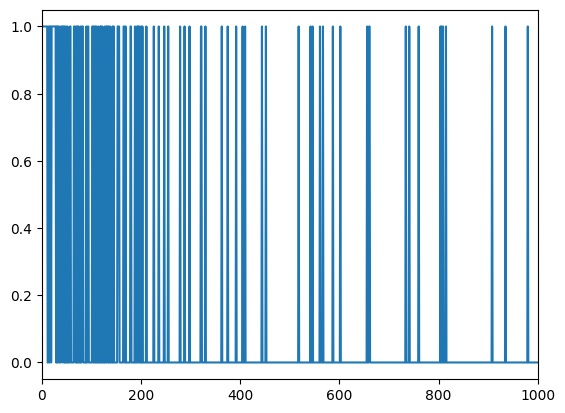

In [16]:
print("'binary' vectorize_layer question:",
      list(binary_vectorize_layer(first_question).numpy()))
plt.plot(binary_vectorize_layer(first_question).numpy())
plt.xlim(0, 1000)

In [17]:
print("'int' vectorize question:",
      int_vectorize_layer(first_question).numpy())

'int' vectorize question: [   1  111    6   23  299 1787  198    2 3623  299 7826    1    1  805
 2568   23    1 1218 3892  364 4145    1    1  661   16    5  981   45
  121 1881   47    1  742   36 9987    8 1982  322  662   36   23 2362
  195  543   83 2693 2609  661  144    1  411    2 1371   23  657    1
 6520   84   66    3  166  104   26 1182    6    5    1 1639   44    3
  189 3623  519 1135    1   44 5468  280 1272   71  156  157    5 1759
    9  331    3  227    2 3623  299  115  810    5  547 3833    3    1
 2371  146  202 1195  289    1    6 2179 1787  193    9  136 1195   45
    6   67  181    4   11  198  106    1    1  299   31    1 2216 1924
   29  299   53   28 2081   22   53   42  170  154  256    7   15  453
   28    1  237 2698    1  134 2698  131 2698  323 2698    1    1    1
    1    1    1   23    1 2216 1924   29  299   22   53   42  170  154
  256 1360   15  453   28  237    1  237   68    9  196  807   28 7167
    1  237    1 1364    1  562    1 4406  735 1820 

## Train the model

In [18]:
binary_model = tf.keras.Sequential([
    binary_vectorize_layer,
    layers.Dense(4)])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

In [19]:
bin_history = binary_model.fit(
    train_ds, validation_data=train_val, epochs=10)

print()

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5208 - loss: 1.2412 - val_accuracy: 0.7750 - val_loss: 0.9134
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8221 - loss: 0.8210 - val_accuracy: 0.8012 - val_loss: 0.7502
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8630 - loss: 0.6532 - val_accuracy: 0.8119 - val_loss: 0.6649
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8873 - loss: 0.5532 - val_accuracy: 0.8194 - val_loss: 0.6116
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9023 - loss: 0.4839 - val_accuracy: 0.8313 - val_loss: 0.5750
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9154 - loss: 0.4316 - val_accuracy: 0.8356 - val_loss: 0.5484
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9265 - loss: 0.3901 - val_accuracy: 0.8400 - val_loss: 0.5284
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9329 - loss: 0.3559 - val_accu

In [20]:
def create_model(vocab_size, num_labels, vectorizer=None):
  my_layers=[]
  if vectorizer is not None:
    my_layers = [vectorizer]
  my_layers.extend([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Dropout(0.5),
      layers.Conv1D(64, 5, padding='valid', activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
  ])
  model = tf.keras.Sequential(my_layers)
  return model

In [21]:
int_model = create_model(vocab_size=VOCAB_SIZE+1, num_labels=4, vectorizer=int_vectorize_layer)


In [22]:
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
int_history = int_model.fit(train_ds, validation_data=train_val, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.3251 - loss: 1.3387 - val_accuracy: 0.6100 - val_loss: 0.9012
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6355 - loss: 0.8493 - val_accuracy: 0.7331 - val_loss: 0.6598
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.7490 - loss: 0.6294 - val_accuracy: 0.7725 - val_loss: 0.5772
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8309 - loss: 0.4781 - val_accuracy: 0.7925 - val_loss: 0.5327
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8822 - loss: 0.3581 - val_accuracy: 0.8056 - val_loss: 0.5151
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9233 - loss: 0.2641 - val_accuracy: 0.8056 - val_loss: 0.5205
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9430 - loss: 0.1953 - val_accuracy: 0.8069 - val_loss: 0.5385
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9622 - loss: 0.1415 - val_accuracy: 0.80

Text(0, 0.5, 'CE/token')

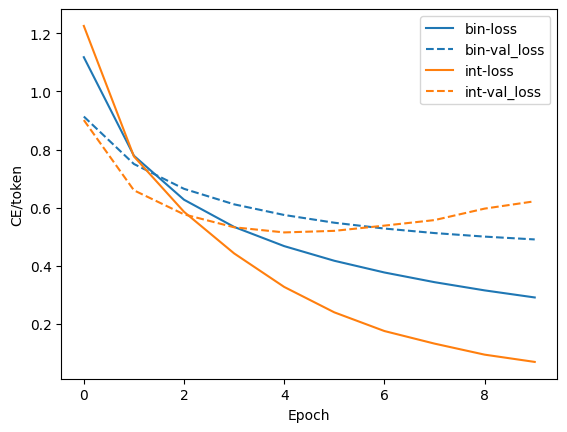

In [23]:
loss=plt.plot(bin_history.epoch, bin_history.history['loss'], label='bin-loss')
plt.plot(bin_history.epoch, bin_history.history['val_loss'], '--', color=loss[0].get_color(), label='bin-val_loss')

loss=plt.plot(int_history.epoch, int_history.history['loss'], label='int-loss')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', color=loss[0].get_color(), label='int-val_loss')

plt.legend()
plt.xlabel("Epoch")
plt.ylabel('CE/token')

Now we are nearly ready to train the model

In [24]:
binary_train_ds = train_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_val_ds = train_val.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_test_ds = test_ds.map(lambda x,y: (binary_vectorize_layer(x), y))

int_train_ds = train_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_val_ds = train_val.map(lambda x,y: (int_vectorize_layer(x), y))
int_test_ds = test_ds.map(lambda x,y: (int_vectorize_layer(x), y))

## Export the model

In [25]:
binary_model.export('bin.tf')

Saved artifact at 'bin.tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.string, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139279133367232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139279150123664: TensorSpec(shape=(), dtype=tf.int64, name=None)
  139279133374976: TensorSpec(shape=(), dtype=tf.string, name=None)
  139279133375328: TensorSpec(shape=(), dtype=tf.int64, name=None)
  139279543702576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139279125971008: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [26]:
loaded=tf.saved_model.load('bin.tf')

In [27]:
binary_model.predict(['How do you sort a list?'])

ValueError: Unrecognized data type: x=['How do you sort a list?'] (of type <class 'list'>)

In [28]:
loaded.serve(tf.constant(['How do you sort a list?'])).numpy()

array([[-0.09904209,  0.01549766, -0.62349623,  0.39436   ]],
      dtype=float32)

## Predict the author of lliad translations

The following provides an example of using tf.data.TextLineDataset to load examples from text files, and Tensorflow Text to preprocess the data. You will use three different English translations of the same work, Homer's lliad, and train a model to identify the translator given a single line of text.

To implement this task you'll use some lower level tools.


*   You'll use ```tf.data.TextLineDataset``` to load text-lines from files
*   You'll implement your own version of ```keras.layers.TextVectorization``` using

*   ```text.UnicodeScriptTokenizer``` - to convert strings to tokesn.
*   ```tf.lookup.StaticVocabularyTable``` - to convert to integer ids.

* You'll maximize performance by placing the text processing in the dataset pipeline, so it can run in parallel with the model training





In [29]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES=['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
  text_dir = utils.get_file(name, origin=DIRECTORY_URL + name)

parent_dir = pathlib.Path(text_dir).parent
list(parent_dir.iterdir())

815980/815980 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
809730/809730 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
807992/807992 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[PosixPath('/root/.keras/datasets/cowper.txt'),
 PosixPath('/root/.keras/datasets/butler.txt'),
 PosixPath('/root/.keras/datasets/derby.txt')]

## Load the dataset
Previously, with ```tf.keras.utils.text_dataset_from_directory``` all contents of a file were treated as a single example. Here, you will use ```tf.data.TextLineDataset```, which is designed to create a ```tf.data.Dataset``` from a text file where each example is a line of text from the original file. ```TextLineData``` is useful for text data that is primarily line-based(for example, poetry or error logs)

Iterate through these files, loading each one into its own dataset. Each example needs to be individually labeled, so use ```Dataset.map``` to apply a labeler function to each one.
This will iterate over every example in the dataset, returning(example, label) pairs

In [30]:
def labeler(example, index):
  return example, tf.cast(index, tf.int64)

In [31]:
labeled_data_sets = []
for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(str(parent_dir/file_name))
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)

Combine these labeled datasets into a single dataset using ```Dataset.concatenate```, and shuffle it with ```Dataset.shuffle```

In [32]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
VALIDATAION_SIZE = 5000

In [33]:
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False
)

Print out a few examples as before. The dataset hasn't been batched yet, hence each entry in all_labeled_data corresponds to one data point:

In [34]:
for text, label in all_labeled_data.take(10):
  print("Sentence: ", text.numpy())
  print("Label:", label.numpy())

Sentence:  b'Troy has taken heart to sally out against them, because they see not'
Label: 2
Sentence:  b'His lawful prize, by highest valour won;'
Label: 1
Sentence:  b'A sturdy ox, and now beneath an oak'
Label: 1
Sentence:  b"Of Nestor's shield, whose praise extends to Heav'n,"
Label: 1
Sentence:  b'He said, and straight the brazen-footed steeds,'
Label: 1
Sentence:  b'protect him and urged him to fall upon the Lelegae and Trojans. No man'
Label: 2
Sentence:  b'The city fronted with bright fires, and heard'
Label: 0
Sentence:  b"Thus as he spoke, across the victims' throats"
Label: 1
Sentence:  b'as we needs must, wounded though we be. When there, we may keep out of'
Label: 2
Sentence:  b"Him answer'd thus AEneas, chief of Troy:"
Label: 1


## Prepare the dataset for training
Instead of using ```tf.keras.layers.TextVectorization``` to preprocess the text dataset, you now use the lower-level TensorFlow Text APIs to standardize and tokenize the data, build a vocabulary and use ```tf.lookup.StaticVocabularyTable``` to map tokens to integers to feed to the model

In [35]:
class MyTokenizer(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.tokenizer = tf_text.UnicodeScriptTokenizer()

  def call(self, text):
    lower_case = tf_text.case_fold_utf8(text)
    result = self.tokenizer.tokenize(lower_case)
    # If you pass a batch of stirngs, it will return a RaggedTensor.
    if isinstance(result, tf.RaggedTensor):
      # convert to dense 0-padded
      result=result.to_tensor()
    return result

In [36]:
tokenizer = MyTokenizer()

In [37]:
tokenized_ds = all_labeled_data.map(lambda text, label: (tokenizer(text), label))
tokenized_ds

<_MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

You can iterate over the dataset and print out a few tokenized examples

In [38]:
for tokens, label in tokenized_ds.take(1):
  break

print(tokens)
print()
print(label)

tf.Tensor(
[b'troy' b'has' b'taken' b'heart' b'to' b'sally' b'out' b'against' b'them'
 b',' b'because' b'they' b'see' b'not'], shape=(14,), dtype=string)

tf.Tensor(2, shape=(), dtype=int64)


Next, we will a build a vocabulary by sorting tokens by frequency and keeping the top ```VOCAB_SIZE``` tokens

In [39]:
tokenized_ds = tokenized_ds.cache().prefetch(tf.data.AUTOTUNE)

vocab_count = collections.Counter()
for toks, labels in tokenized_ds.ragged_batch(1000):
  toks = tf.reshape(toks, [-1])
  for tok in toks.numpy():
    vocab_count[tok] += 1

vocab = [tok for tok, count in vocab_count.most_common(VOCAB_SIZE)]
print("First five vocab entries:", vocab[:5])
print()

First five vocab entries: [b',', b'the', b'and', b"'", b'of']



To convert the tokens into integers, use the vocab set to create a ```tf.lookup.StaticVocabularyTable```. You will map tokens to integers with 0 reserved for padding, and n+1 reserved to denote an out-of-vocabulary(OOV) token

In [40]:
class MyVocabTable(tf.keras.layers.Layer):
  def __init__(self, vocab):
    super().__init__()
    self.keys=[''] + vocab
    self.values=range(len(self.keys))

    self.init=tf.lookup.KeyValueTensorInitializer(
        self.keys, self.values, key_dtype=tf.string, value_dtype=tf.int64)
    num_oov_buckets=1

    self.table = tf.lookup.StaticVocabularyTable(self.init, num_oov_buckets)

  def call(self, x):
    result = self.table.lookup(x)
    return result